Trabajo ejemplo tomado del curso de Inteligencia Artificial IA2023II. El ejemplo está construido con un conjunto de datos disponible en Kaggle: https://www.kaggle.com/datasets/fedesoriano/gisette-dataset-mnist-digits-4-and-9/data

# Gisette Dataset (MNIST digits 4 and 9)
En el actual notebook se encuentra el código necesario para realizar los diferentes métodos de Machine Learning:
* Arbol de decisión
* Random Forest
* Redes Neuronales
* Redes Neuronales Profundas

## Descipción del problema
El problema de **GISETTE** es un problema de reconocimiento de dígitos escritos a mano. Es un problema de clasificación el cual consiste en separar los dígitos '4' y '9', que son altamente confusos.


Este dataset fue usado originalmente en un taller de NIPS (Neural Information Processing Systems), una conferencia en la que llegan varios investigadores de distintas partes del mundo a dar charlas, que usualmente son seguidas por un taller en el que varios grupos de investigadores participan en una competencia para ver quien puede puede proponer el mejor algoritmo de **feature selection**. 

Los autores a los que se le atribuye la publicación del dataset son:
* Isabelle Guyon
* Steve Gunn
* Asa Ben-Hur
* Gideon Dror

Sin embargo, para esta implementación utilizaremos la versión modificada por un usuario de Kaggle llamado *fedesoriano*, que la ha montado en la misma plataforma. Su trabajo fue el de reunir todas las imagenes y Labels en el mismo archivo para posteriormente convertirlas en un archivo pickle, de manera que sea mas fácil de acceder y cargar los datos para su uso. El dataset está disponible en el [siguiente link](https://www.kaggle.com/datasets/fedesoriano/gisette-dataset-mnist-digits-4-and-9/data).

Los dígitos y datos originales fueron preprocesados, ya que las imágenes de los dígitos fueron todas normalizadas a un tamaño de 28x28 pixeles. Los siguientes son ejemplos de las imágenes:

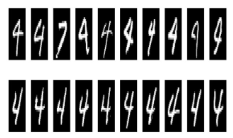

Sin embargo, solamente se usaron ciertos píxeles de la parte superior central de la imagen (muestreados al azar) para crear este dataset y por último se crearon nuevas características multiplicando los valores de algunos pixeles para aumentar la dimensionalidad.

El reto que nos propone el dataset es construir un algoritmo de aprendizaje automático que sea capaz de seleccionar las características apropiadas, ya que el conjunto de datos incluye un total de 5000 características de las cuales 2500 no tienen poder predictivo.

## Contenido del dataset
Para poder realizar una visualización de los datos necesitaremos las siguientes librerías:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import tree, ensemble, neural_network
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Como los datos se encuentran en el archivo gisette.pickle, tenemos que exportar los datos.

In [3]:
gisette_data = pd.read_pickle(r'gisette.pickle')
gisette_data

{'training': {'data': array([[550.,   0., 495., ...,   0.,   0., 983.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0., 991., ...,   0.,   0., 991.]]),
  'labels': array([ 1., -1.,  1., ..., -1., -1., -1.])},
 'validation': {'data': array([[688.,   0.,   0., ...,   0., 769.,   0.],
         [778., 758.,   0., ...,   0.,   0.,   0.],
         [469.,   0., 816., ..., 417.,   0.,   0.],
         ...,
         [  0.,   0.,   0., ...,   0.,   0., 742.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
  'labels': array([ 1.,  1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1., -1.,
          1., -1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,
          1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,
         -1.,

Confirmamos que los datos están guardados en forma de diccionario

In [4]:
type(gisette_data)

dict

Mostramos las llaves de este diccionario.

In [5]:
gisette_data.keys()

dict_keys(['training', 'validation', 'testing'])

Estas contienen otra llave que separa los datos puros de sus Labels o variable a predecir, a excepción de la de testing.

In [6]:
print('Training keys: ',gisette_data['training'].keys())
print('Validation keys: ',gisette_data['validation'].keys())
print('Testing keys: ',gisette_data['testing'].keys())

Training keys:  dict_keys(['data', 'labels'])
Validation keys:  dict_keys(['data', 'labels'])
Testing keys:  dict_keys(['data'])


Recapitulando, este dataset nos devuelve un diccionario, el cual contiene 3 claves: **training**, **validation** y **testing**. Cada una de estas claves tiene su valor, en la que cada valor son los datos o características representados como **data** y la variable a predecir llamada **labels** a excepción de **testing** que simplemente tiene los datos y no la variable a predecir. 

En este caso la variable a predecir o **labels** representan si es un 4 o un 9, por lo cual si *label=-1* representa al dígito 9 y si *label=1* representa al dígito 4. Ya que el resultado es binario, es decir solo puede ser 1 o -1, nos encontramos con un problema de **clasificación**, en el que nuestros algoritmos tienen que predecir el valor de una variable discreta.

Se observa igualmente que los datos que nos proporciona el dataset para entrenar, validar y testear el modelo tienen diferentes ejemplos o filas. Sin embargo, para testear el modelo, utilizaremos los datos que nos proporciona *validation* ya que los datos de *testing* no tienen una variable a predecir, y nuestra intención es realizar un aprendizaje supervisado.

In [7]:
print('Examples of training data:',len(gisette_data['training']['data']))
print('Examples of validation data:',len(gisette_data['validation']['data']))
print('Examples of testing data:',len(gisette_data['testing']['data']))

Examples of training data: 6000
Examples of validation data: 1000
Examples of testing data: 6500


## Análisis de los datos
Para poder analizar los datos, utilizaremos el conjunto de datos de **training** y lo convertiremos a un objeto de tipo DataFrame. Luego se muestra información importante sobre los datos.

Como las carácteristicas que tenemos en este conjunto de datos no tienen algún nombre, ya que son un *color de escala de grises* pertenecientes a un *pixel cualquiera*, y estos pixeles que nos entrega están desordenados, decidimos colocarle el nombre genérico de "feature_x" a cada carácteristica donde x es el orden en el que aparecen al visualizar la tabla. Por último agregamos la columna de los Labels al final para su visualización.

In [8]:
training_data = gisette_data['training']['data']
training_labels = gisette_data['training']['labels']
# Convertir los datos en un objeto de tipo DataFrame de la libreria Pandas
X = pd.DataFrame(data=training_data, columns=['feature_'+str(i) for i in range(len(training_data[0]))])
X['labels'] = training_labels
# Se muestra la información de los datos
X.info(verbose=True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 5001 columns):
 #     Column        Non-Null Count  Dtype  
---    ------        --------------  -----  
 0     feature_0     6000 non-null   float64
 1     feature_1     6000 non-null   float64
 2     feature_2     6000 non-null   float64
 3     feature_3     6000 non-null   float64
 4     feature_4     6000 non-null   float64
 5     feature_5     6000 non-null   float64
 6     feature_6     6000 non-null   float64
 7     feature_7     6000 non-null   float64
 8     feature_8     6000 non-null   float64
 9     feature_9     6000 non-null   float64
 10    feature_10    6000 non-null   float64
 11    feature_11    6000 non-null   float64
 12    feature_12    6000 non-null   float64
 13    feature_13    6000 non-null   float64
 14    feature_14    6000 non-null   float64
 15    feature_15    6000 non-null   float64
 16    feature_16    6000 non-null   float64
 17    feature_17    6000 non-null  

Aquí podemos ver que no hay algun dato nulo o faltante en el conjunto, lo cual es muy conveniente ya que nos ayuda a omitir gran parte de los pasos de limpieza de datos.

Igualmente, veremos unos datos adicionales que nos proporciona la libería *Pandas* al utilizar uno de sus métodos, el cual nos permitirá tener un mejor entendimiento de los datos ahora que los podemos visualizar.

In [9]:
X.describe()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4991,feature_4992,feature_4993,feature_4994,feature_4995,feature_4996,feature_4997,feature_4998,feature_4999,labels
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.00000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,111.022833,11.251000,173.261167,0.951000,15.169167,50.209333,15.206333,323.073167,2.207667,146.355667,...,111.407500,2.035333,318.539667,81.03950,44.777333,263.813667,14.720667,122.423500,153.636000,0.000000
std,284.848291,91.448864,341.759463,25.771877,109.238579,194.682629,106.963813,418.413159,39.746428,317.863306,...,276.658528,41.781918,420.830651,256.10652,185.273192,394.966054,106.994417,294.247413,326.609648,1.000083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,786.000000,0.000000,0.000000,...,0.000000,0.000000,790.250000,0.00000,0.000000,659.250000,0.000000,0.000000,0.000000,1.000000
max,999.000000,999.000000,999.000000,983.000000,999.000000,999.000000,999.000000,999.000000,991.000000,999.000000,...,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,999.000000,1.000000


Como se puede observar, el conjunto de datos contiene en total 5000 características, representadas en este caso desde el pixel 0 al pixel 4999 y en la columna 5000 el valor de label en cada respectivo ejemplo.
## Distribución de las Clases
Visualizando la distribución de las clases a través de un histograma.

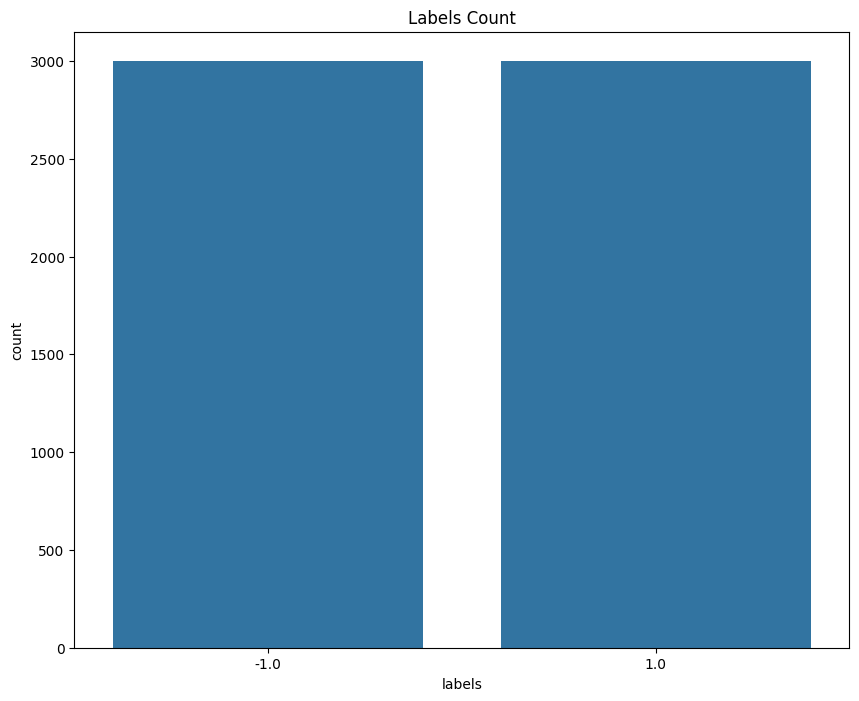

In [10]:
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(data=X, x="labels")
plt.title("Labels Count")
plt.show()

Como ya vimos anteriomente nuestro conjunto de datos de entrenamiento tiene 6000 ejemplos, y teniendo en cuenta el gráfico anterior, nuestro conjunto de datos se encuentra balanceado debido a que cada clase tiene, según el gráfico, 3000 ejemplos.

## Feature Engineering
En primer lugar separamos las variables predictoras de las variables a predecir

In [11]:
X_train = X.drop(['labels'], axis=1) # Separa las variables predictoras de las variable a predecir
y_train = X['labels']

Luego aplicamos el método de Principal Component Analysis (PCA) para poder realizar una reducción de la dimensionalidad evaluando que la varianza de los datos no varíe mucho, por lo que debe ser cercano a 1

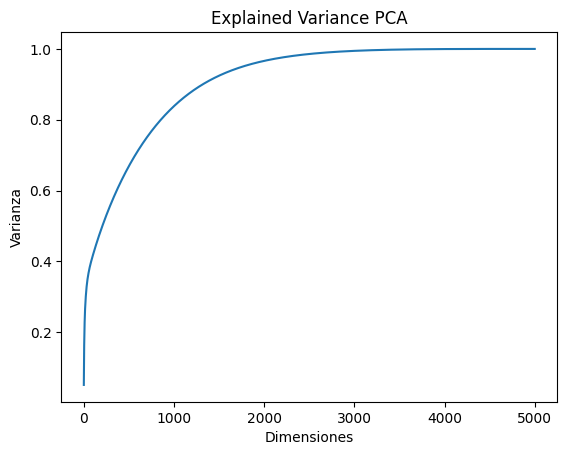

In [12]:
# Principal Component Analysis
pca = PCA()

X_train_PCA = pca.fit_transform(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.xlabel('Dimensiones')
plt.ylabel('Varianza')
plt.title("Explained Variance PCA")
plt.show()
train_index = range(0,len(X_train))
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)

A continuación evaluaremos la varianza de todo el conjunto de datos de entrenamiento.

In [13]:
# Percentage of Variance Captured by 500 principal components
print("Variance Explained by all 5000 principal components: ", \
      sum(pca.explained_variance_ratio_))

Variance Explained by all 5000 principal components:  0.9999999999999994


La varianza es *muy alta*, aproximándose a 1 lo cual es algo muy beneficioso. Sin embargo, al tener 5000 carácteristicas tenemos que evaluar si se puede reducir la dimensionalidad, veremos a continuación que tanto se reduce la varianza si tomamos una muestra mas pequeña de datos.

In [14]:
# Percentage of Variance Captured by X principal components
importanceOfPrincipalComponents = \
    pd.DataFrame(data=pca.explained_variance_ratio_)
importanceOfPrincipalComponents = importanceOfPrincipalComponents.T

print('Variance Captured by First 1000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:999].sum(axis=1).values)
print('Variance Captured by First 1500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1499].sum(axis=1).values)
print('Variance Captured by First 2000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:1999].sum(axis=1).values)
print('Variance Captured by First 2500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2499].sum(axis=1).values)
print('Variance Captured by First 3000 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:2999].sum(axis=1).values)
print('Variance Captured by First 3500 Principal Components: ',
      importanceOfPrincipalComponents.loc[:,0:3499].sum(axis=1).values)

Variance Captured by First 1000 Principal Components:  [0.83827664]
Variance Captured by First 1500 Principal Components:  [0.92441109]
Variance Captured by First 2000 Principal Components:  [0.96620063]
Variance Captured by First 2500 Principal Components:  [0.98569556]
Variance Captured by First 3000 Principal Components:  [0.99453533]
Variance Captured by First 3500 Principal Components:  [0.99826127]


Como se puede observar las varianzas a partir de 3500 datos en adelante ya son muy cercanas a 1, por lo que podríamos aplicar nuestra primera reducción.

En este caso, realizaremos una reducción de 2500 dimensiones o características ya que al eliminarlas podemos observar que la varianza sigue siendo cercana a 1, por lo que es una muy buena opción.

In [15]:
# Another option to delete features
# X_train = X_train_PCA[X_train_PCA.columns[:-2500]]
# X_train
pca = PCA(n_components=2500)
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=train_index)
X_train_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,10625.490378,2640.714856,6733.280600,8270.670175,1052.453861,-1268.286528,2136.147281,2995.585036,-2717.134945,3821.922620,...,130.655852,75.210363,-74.722218,76.838893,56.669896,24.188311,-29.770215,172.713863,87.269068,-65.789851
1,5046.238859,-5301.992984,-4247.276014,-2492.178743,194.714529,453.653399,-571.140707,4750.232961,127.713598,1509.927317,...,-90.896279,22.948608,-44.345069,142.762331,-13.182179,91.944666,161.206935,83.263265,105.072372,-14.285445
2,1814.154499,-5894.792481,-2199.482361,2353.499823,3805.579323,-1156.720641,748.739064,-1887.485214,1264.444842,2083.392791,...,84.681569,73.917051,-34.220746,-41.118176,74.788307,-97.431261,84.511018,-100.861438,0.632628,102.322000
3,4029.656430,-698.929215,95.233834,-2731.711253,2911.977481,-4642.479910,-1369.477445,2814.959907,-1506.103560,-296.072679,...,39.233761,3.987161,31.159207,-161.537501,-196.333348,-75.660848,-167.348783,7.896084,77.788997,73.711267
4,-5245.527368,475.361630,815.049564,-144.896441,-1065.833262,716.204011,-710.111986,-1606.667073,-1134.278057,-900.596161,...,97.423323,155.016175,33.337184,-91.614550,8.285116,114.930855,70.252520,-18.597664,-13.652965,58.371534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-2232.530331,2903.425664,-2139.586195,-1989.168746,1036.238436,-906.768239,609.273121,-858.406282,233.767713,2601.705092,...,-181.508047,-183.890608,-85.805756,81.441796,61.206444,-236.198355,138.481784,-23.022370,-55.757838,14.803341
5996,-3210.592532,1263.522049,149.225021,4161.845139,-780.867347,650.869990,-3466.330484,335.227646,-282.304989,-2333.403824,...,67.608725,155.847335,58.746517,-178.562866,-7.537492,-141.748786,123.090571,-39.847179,155.733804,-55.923515
5997,875.082297,-5584.875465,-2768.445532,-1023.469035,-512.926243,2012.906319,-3582.173132,3099.537879,201.573706,110.640599,...,-21.338900,-50.877896,26.291590,-49.538681,50.396222,134.067229,-37.188834,59.689707,-15.616607,-48.074010
5998,-1065.712792,-4327.673850,2537.088454,-938.046345,-330.796766,-612.323790,-1430.262026,-693.794464,1026.712826,-131.405789,...,-119.489438,-7.311609,-121.478135,7.156410,74.249074,-61.156266,-77.975609,-77.798857,-97.621522,43.647203


c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


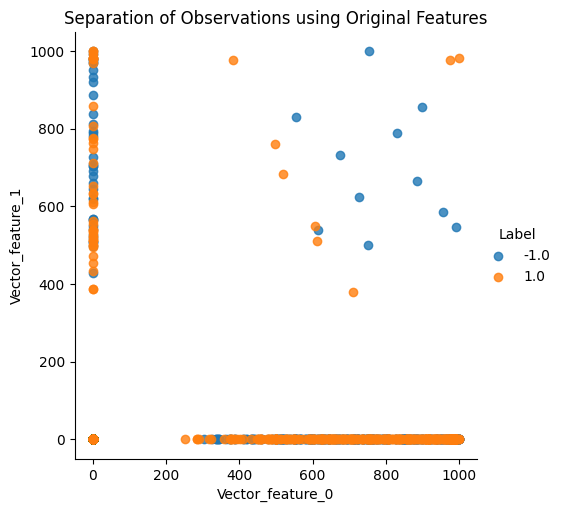

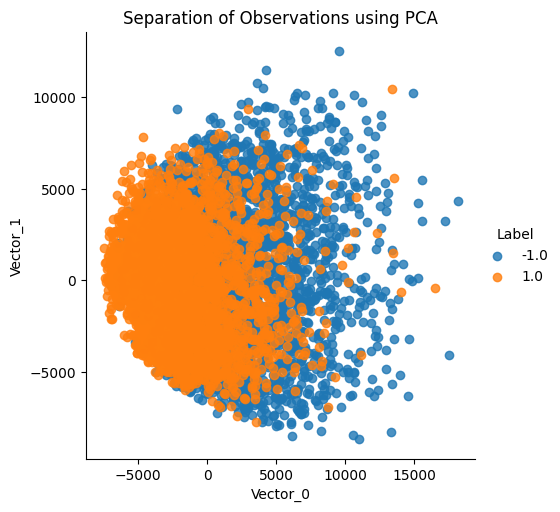

In [16]:

def scatterPlot(xDF, yDF, algoName, col1, col2):
    tempDF = pd.DataFrame(data=xDF.loc[:,[col1,col2]], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    v1 = f"Vector_{col1}"
    v2 = f"Vector_{col2}"
    tempDF.columns = [v1, v2, "Label"]
    sns.lmplot(x=v1, y=v2, hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

scatterPlot(X_train, y_train, "Original Features", 'feature_0', 'feature_1')
scatterPlot(X_train_PCA, y_train, "PCA", 0, 1)


Ya eliminadas las dimensiones de nuestro dataset de entrenamiento, tenemos que transformar igualmente los datos que utilizaremos para testear el modelo, por lo que utilizaremos los mismos egenvectores creados anteriormente en nuestro PCA para convertir nuestros datos

In [17]:
validation_data = gisette_data['validation']['data']
y_validation = gisette_data['validation']['labels']

X_validation = pd.DataFrame(data=validation_data, columns=['feature_'+str(i) for i in range(len(validation_data[0]))])
X_validation_PCA = pca.transform(X_validation)
validation_index = range(0,len(X_validation))
X_validation_PCA = pd.DataFrame(data=X_validation_PCA, index=validation_index)
X_validation_PCA

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,-803.888690,-3037.055967,-3523.337816,-749.396375,2514.678447,711.547801,677.346349,-1453.532295,3443.612862,-1271.466222,...,205.281758,-55.658921,35.037682,-131.944393,199.145527,214.712583,-54.894782,-83.972489,-93.712858,10.930425
1,-3792.161778,1733.063694,1863.417378,3315.044262,320.421031,6299.942971,-425.161966,-1926.443426,888.168743,544.846398,...,144.530641,81.960711,-153.669861,115.915304,-199.611911,28.852853,-115.444534,-271.843516,-32.430890,-104.667053
2,-2094.614492,4248.354006,-4356.378938,-1866.296383,3433.079856,227.263773,2633.290316,-319.199298,444.948828,538.111454,...,12.330218,-134.084153,183.723921,201.102562,-90.048025,-108.328366,122.049725,-41.991194,-25.629231,150.990847
3,-2959.662707,-1297.261396,-364.368436,2079.135031,-1390.801318,-3738.134639,-1625.804610,1721.081058,-3496.279560,1390.072397,...,93.828843,3.003923,163.392336,23.876457,-11.834256,106.843119,-104.786912,125.077339,-155.062099,239.332527
4,-4183.689977,-2822.237482,-203.459795,1010.009601,-614.553813,-3413.042264,-232.506897,1366.180554,-548.925615,-435.283611,...,-198.345737,-139.323320,189.979746,-403.035878,77.375557,-11.331048,-32.666462,152.886538,70.551979,89.253633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1701.653682,-1496.392050,-4706.788349,-2587.262066,-1185.458548,1424.773715,1223.014999,-1410.624274,-1311.138773,-2635.645293,...,63.315307,-132.392277,48.327914,216.733787,-75.708654,-73.112644,-223.503312,-114.562711,48.806603,18.244853
996,3246.894530,-798.948861,5298.153452,-324.153008,6074.735915,4022.526997,5269.206357,-5067.112590,-929.870582,-16.671301,...,144.313419,-109.057274,-210.857633,-238.619417,-252.051382,126.531388,227.139166,43.104361,320.892507,332.803446
997,-205.806891,5363.290338,5143.201032,667.650743,-3713.705459,1442.718870,5000.201648,-2393.327830,653.529140,277.730351,...,126.636718,-65.433549,269.557029,-1.877613,34.358087,-93.757692,-25.969913,-21.714379,199.574590,-282.825352
998,-177.125146,-3771.959878,-1333.895517,-2414.677511,-3758.326116,1461.779098,-1652.138342,1765.732570,-385.419763,575.854876,...,0.122479,-94.111567,82.197371,-36.128700,56.173086,-118.290826,240.292256,-91.475670,198.210219,-40.128097


### Prueba de feature selection
**Filter method:** Luego de llevar a cabo el método de PCA para reducir dimensionalidad realizaremos un método de selección de características y en este caso en particular será el método de filtro de correlación, por medio del cual eliminaremos las variables que menos correlación tengan con la variable a predecir usando correlación de Spearman

In [18]:
fs = pd.DataFrame(X_train_PCA)
fs['target'] = y_train
corr_matrix = fs.corr(method='spearman')
corr_matrix = corr_matrix.abs().unstack()
corr_target = corr_matrix['target'].sort_values(ascending=False) 
corr_target

target    1.000000
3         0.535174
0         0.463150
6         0.318902
2         0.197682
            ...   
1525      0.000028
1935      0.000024
701       0.000016
563       0.000007
1298      0.000007
Length: 2501, dtype: float64

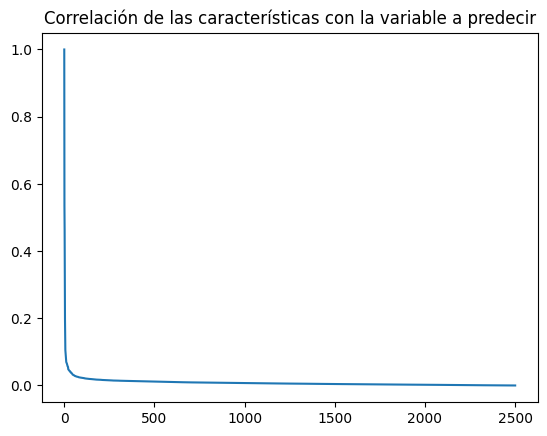

In [19]:
plt.plot(corr_target.values)
plt.title("Correlación de las características con la variable a predecir")
plt.show()

Como se puede observar, existen aproximadamente 2000 características que no tienen mucha correlación con respecto a la variable a predecir, por lo tanto, seleccionaremos un umbral de 0.056 para seleccionar nuestras características.

In [20]:
features_selected = corr_target[corr_target > 0.056]
features_selected

target    1.000000
3         0.535174
0         0.463150
6         0.318902
2         0.197682
5         0.140689
41        0.105567
24        0.098002
11        0.091735
13        0.081837
19        0.071585
10        0.069888
16        0.067694
35        0.066867
4         0.066144
1         0.063935
15        0.061133
46        0.058529
18        0.058056
43        0.056159
dtype: float64

Como se puede observar, claramente seleccionando 19 características tendríamos suficiente para entrenar los modelos con gran precisión, ya que si seleccionamos un umbral mayor a este, el modelo estaría en riesgo que quedar sobreajustado a los datos de entrenamiento. Por consiguiente seleccionaremos las 19 características anteriormente vistas tanto en los datos de entrenamiento como en los datos de prueba.

In [21]:
X_train_fs = X_train_PCA[features_selected.index.drop("target")]
X_test_fs = X_validation_PCA[features_selected.index.drop("target")]
X_train_fs

,3,0,6,2,5,41,24,11,13,19,10,16,35,4,1,15,46,18,43
0,8270.670175,10625.490378,2136.147281,6733.280600,-1268.286528,-588.915268,-1406.301230,1313.350402,1146.643281,387.494460,1461.061080,-2281.306810,311.948205,1052.453861,2640.714856,-1865.469280,-774.005862,-230.614451,-236.412143
1,-2492.178743,5046.238859,-571.140707,-4247.276014,453.653399,1057.942038,-1489.220502,1054.749914,1017.496281,1186.080159,-2415.996819,-95.257756,455.754636,194.714529,-5301.992984,-105.218385,701.692766,-2069.004027,227.315452
2,2353.499823,1814.154499,748.739064,-2199.482361,-1156.720641,-199.411852,-1186.023920,-1008.621964,1384.901581,1612.143898,1823.112377,-470.976894,-1237.189431,3805.579323,-5894.792481,-2031.469975,-970.279327,524.281102,186.807363
3,-2731.711253,4029.656430,-1369.477445,95.233834,-4642.479910,-230.578249,-199.918400,4209.479324,-770.218086,923.424031,3464.529759,-1844.195166,-1364.876022,2911.977481,-698.929215,-2369.553082,516.534033,2007.711872,-846.553960
4,-144.896441,-5245.527368,-710.111986,815.049564,716.204011,495.439764,-703.698297,-1643.948054,2166.517129,99.118034,-385.936985,692.607935,186.024289,-1065.833262,475.361630,957.047040,-716.887227,-1130.508592,-182.458262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,-1989.168746,-2232.530331,609.273121,-2139.586195,-906.768239,-247.072936,-660.517713,-3368.104604,2185.611001,-101.898282,-462.088789,2404.719345,400.460519,1036.238436,2903.425664,-154.953727,-137.104541,498.020592,-1076.878085
5996,4161.845139,-3210.592532,-3466.330484,149.225021,650.869990,-27.348383,233.308085,606.438931,2735.453881,-1015.082343,90.113010,-930.071640,-126.511200,-780.867347,1263.522049,-62.226767,167.866261,1251.566916,-821.568352
5997,-1023.469035,875.082297,-3582.173132,-2768.445532,2012.906319,-281.351248,-1028.998877,253.844120,-804.560354,1105.647616,-63.034722,-612.661365,-689.977313,-512.926243,-5584.875465,147.827880,-225.508341,168.818511,907.779036
5998,-938.046345,-1065.712792,-1430.262026,2537.088454,-612.323790,1633.519058,604.036904,-1005.522910,-2375.195507,173.578303,-1708.391960,-818.627963,198.830439,-330.796766,-4327.673850,1720.879632,-96.743530,-1263.504731,50.160656


Luego de esto podremos entrenar los métodos para comparar entre hacer o no hacer selección de características y observar su efectividad.

## Pruebas de eficacia
Para probar la eficiencia de la selección de características y con ánimos de observar si nuestro modelo no queda sobre ajustado a los datos de entrenamiento, entrenaremos dos modelos, uno con las 20 características después de aplicar selección de características y otro con las 2500 características luego de aplicar reducción de dimensionalidad.

Todos los modelos tendrán los parámetros por defecto para tener igualdad de condiciones.

**Arbol de decisiones**

In [22]:
clf_PCA = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_fs = tree.DecisionTreeClassifier(criterion='entropy', splitter='best')
clf_PCA = clf_PCA.fit(X_train_PCA,y_train)
clf_fs = clf_fs.fit(X_train_fs,y_train)

#Evaluación en el conjunto de prueba
y_pred_PCA = clf_PCA.predict(X_validation_PCA)
y_pred_fs = clf_fs.predict(X_test_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_PCA.score(X_validation_PCA, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(clf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(clf_fs.score(X_test_fs, y_validation))) 

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.86
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.90


**Random Forest**

In [23]:
rf_PCA = ensemble.RandomForestClassifier(criterion='entropy')
rf_fs = ensemble.RandomForestClassifier(criterion='entropy')
rf_PCA = rf_PCA.fit(X_train_PCA,y_train)
rf_fs = rf_fs.fit(X_train_fs,y_train)

y_pred_PCA = rf_PCA.predict(X_validation_PCA)
y_pred_fs = rf_fs.predict(X_test_fs)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_PCA.score(X_train_PCA, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_PCA.score(X_validation_PCA, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(rf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.2f}'.format(rf_fs.score(X_test_fs, y_validation))) 

=========================== ACCURACY WITH PCA ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.87
=========================== ACCURACY WITH FS ===========================
Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.95


**Redes neuronales**

In [24]:
# Se realiza el escalamiento de los datos para que el modelo converja más rápido
min_max_scaler = preprocessing.MinMaxScaler()

X_train_PCA_scaler = min_max_scaler.fit_transform(X_train_PCA)
X_validation_PCA_scaler = min_max_scaler.fit_transform(X_validation_PCA)

X_train_fs_scaler = min_max_scaler.fit_transform(X_train_fs)
X_test_fs_scaler = min_max_scaler.fit_transform(X_test_fs)

In [25]:
mlp_PCA = neural_network.MLPClassifier()
mlp_fs = neural_network.MLPClassifier()
mlp_PCA = mlp_PCA.fit(X_train_PCA_scaler,y_train)
mlp_fs = mlp_fs.fit(X_train_fs_scaler,y_train)

y_pred_PCA = mlp_PCA.predict(X_validation_PCA_scaler)
y_pred_fs = mlp_fs.predict(X_test_fs_scaler)
print('=========================== ACCURACY WITH PCA ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_PCA.score(X_train_PCA_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_PCA.score(X_validation_PCA_scaler, y_validation))) 
print('=========================== ACCURACY WITH FS ===========================')
print('Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: {:.2f}'.format(mlp_fs.score(X_train_fs_scaler, y_train)))
print('Accuracy de MLPClassifier sobre el conjunto de prueba es: {:.2f}'.format(mlp_fs.score(X_test_fs_scaler, y_validation))) 

c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


=========================== ACCURACY WITH PCA ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 1.00
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.90
=========================== ACCURACY WITH FS ===========================
Accuracy de MLPClassifier sobre el conjunto de entrenamiento es: 0.97
Accuracy de MLPClassifier sobre el conjunto de prueba es: 0.86


c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Como se puede observar, el método de red neuronal no alcanza a converger, por lo que necesitaría más iteraciones para encontrar su mejor solución.

**Redes neuronales profundas**

**Comparación en los 3 métodos**: A continuación se hace una comparación de los 3 métodos según el accuracy que recibió la predicción con el conjunto de prueba de cada modelo.

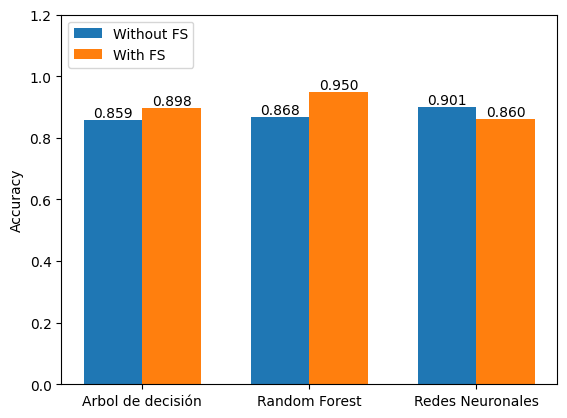

In [26]:
clf_score_PCA = clf_PCA.score(X_validation_PCA, y_validation)
clf_score_fs = clf_fs.score(X_test_fs, y_validation)
rf_score_PCA = rf_PCA.score(X_validation_PCA, y_validation)
rf_score_fs = rf_fs.score(X_test_fs, y_validation)
mlp_score_PCA = mlp_PCA.score(X_validation_PCA_scaler, y_validation)
mlp_score_fs = mlp_fs.score(X_test_fs_scaler, y_validation)

fig, ax = plt.subplots()
rects1=ax.bar(np.arange(3)-0.35/2,[clf_score_PCA,rf_score_PCA,mlp_score_PCA],0.35,label="Without FS")
rects2=ax.bar(np.arange(3)+0.35/2,[clf_score_fs,rf_score_fs,mlp_score_fs],0.35,label="With FS")

for rect in rects1:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.3f' % height, ha='center', va='bottom')

for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.3f' % height, ha='center', va='bottom')

ax.set_ylabel('Accuracy')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(["Arbol de decisión","Random Forest","Redes Neuronales"])
ax.legend(loc='upper left')
ax.set_ylim(0, 1.2)

plt.show()

Como se puede observar utilizando los modelos de Machine Learning el accuracy mejora cuando se realiza una selección de características, por lo cual, se procederá a realizar las pruebas de aquí en adelante con el conjunto de datos que tiene 19 características, es decir, al que se le realizó ***feature selection***.

## Decision Tree
### Prueba con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defectos, veremos el score, el reporte de clasificación y la matriz de confusión

In [27]:
print('Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(clf_fs.score(X_train_fs, y_train)))
print('Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: {:.3f}'.format(clf_fs.score(X_test_fs, y_validation)))

Accuracy de DecisionTreeClassifier sobre el conjunto de entrenamiento es: 1.000
Accuracy de DecisionTreeClassifier sobre el conjunto de prueba es: 0.898


In [28]:
# Validación cruzada
cross_val_scores = cross_val_score(clf_fs, X_train_fs, y_train, cv=5)
print("Resultados de la validación cruzada:")
print(cross_val_scores)
print("Precisión media: {:.2f}".format(cross_val_scores.mean()))

Resultados de la validación cruzada:
[0.91833333 0.89333333 0.90416667 0.8925     0.90583333]
Precisión media: 0.90


In [29]:
y_pred_test = clf_fs.predict(X_test_fs)
y_pred_train = clf_fs.predict(X_train_fs)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.91      0.88      0.90       500
         1.0       0.89      0.91      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



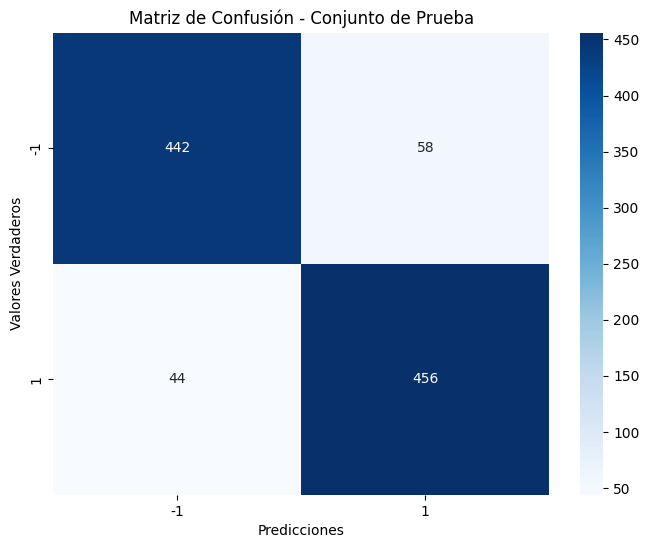

In [30]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

### Prueba de parámetros con GridSearch

In [31]:
param_grid = {
    'criterion' : ['gini','entropy'],
    'max_depth': [None, 5, 10, 20, 100],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf':[2,4,10,20,50,100]}

model = tree.DecisionTreeClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy')
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 100],
                         'min_samples_leaf': [2, 4, 10, 20, 50, 100],
                         'min_samples_split': [2, 4, 6, 8]},
             scoring='accuracy')

In [32]:
print(grid_search.best_params_)

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4}


In [33]:
predictions = grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.901


In [34]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99      3000
         1.0       1.00      0.98      0.99      3000

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.90      0.90      0.90       500
         1.0       0.90      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



## Random Forest
### Pruebas con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defecto, veremos el score, el reporte de clasificación y la matriz de confusión.

In [35]:
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(rf_fs.score(X_train_fs, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.3f}'.format(rf_fs.score(X_test_fs, y_validation)))

Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 1.000
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.950


In [36]:
y_pred_test = rf_fs.predict(X_test_fs)
y_pred_train = rf_fs.predict(X_train_fs)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00      3000
         1.0       1.00      1.00      1.00      3000

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.95      0.95      0.95       500
         1.0       0.95      0.95      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



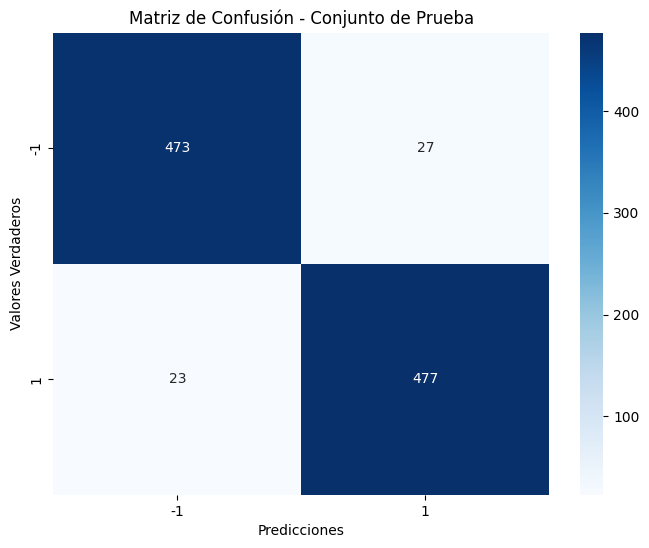

In [37]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

### Prueba de parámetros con GridSearch

In [64]:
param_grid = {
    'n_estimators': [150,200,250,300],
    'criterion' : ['gini','entropy'],
    'max_depth': [None, 5, 10, 20, 100],
    'min_samples_split' : [2, 4, 6, 8],
    'min_samples_leaf':[2,4,10,20,50]}

model = ensemble.RandomForestClassifier(n_jobs=-1)
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy')
grid_search.fit(X_train_fs, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 20, 100],
                         'min_samples_leaf': [2, 4, 10, 20, 50],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [150, 200, 250, 300]},
             scoring='accuracy')

In [65]:
print(grid_search.best_params_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 250}


In [66]:
predictions = grid_search.predict(X_test_fs)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.907


In [67]:
y_pred_train = grid_search.predict(X_train_fs)
y_pred_test  = grid_search.predict(X_test_fs)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.98      0.98      0.98      3000
         1.0       0.98      0.98      0.98      3000

    accuracy                           0.98      6000
   macro avg       0.98      0.98      0.98      6000
weighted avg       0.98      0.98      0.98      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.92      0.89      0.91       500
         1.0       0.90      0.92      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



## Redes Neuronales
### Pruebas con parámetros por defecto
Como anteriormente se realizó el entrenamiento del modelo con los parámetros por defecto, veremos el score, el reporte de clasificación y la matriz de confusión.

In [38]:
print('Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: {:.3f}'.format(mlp_fs.score(X_train_fs_scaler, y_train)))
print('Accuracy de RandomForestClassifier sobre el conjunto de prueba es: {:.3f}'.format(mlp_fs.score(X_test_fs_scaler, y_validation)))

Accuracy de RandomForestClassifier sobre el conjunto de entrenamiento es: 0.969
Accuracy de RandomForestClassifier sobre el conjunto de prueba es: 0.860


In [39]:
y_pred_test = mlp_fs.predict(X_test_fs_scaler)
y_pred_train = mlp_fs.predict(X_train_fs_scaler)

print("Reporte de clasificación entrenamiento: ")
print(classification_report(y_train, y_pred_train))
print("==============================================================")
print("Reporte de clasificación prueba: ")
print(classification_report(y_validation, y_pred_test))

Reporte de clasificación entrenamiento: 
              precision    recall  f1-score   support

        -1.0       0.96      0.97      0.97      3000
         1.0       0.97      0.96      0.97      3000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

Reporte de clasificación prueba: 
              precision    recall  f1-score   support

        -1.0       0.78      1.00      0.88       500
         1.0       0.99      0.72      0.84       500

    accuracy                           0.86      1000
   macro avg       0.89      0.86      0.86      1000
weighted avg       0.89      0.86      0.86      1000



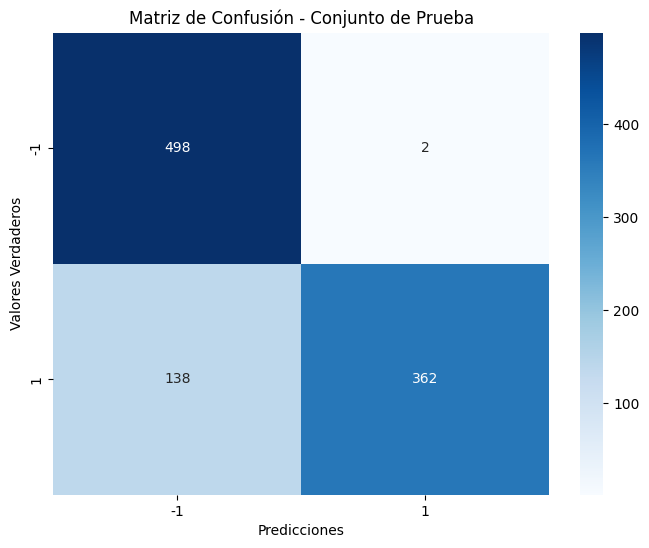

In [40]:
# Crear la matriz de confusión para el conjunto de prueba
cmatrix = confusion_matrix(y_validation, y_pred_test)

# Crear el mapa de calor para el conjunto de prueba
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(cmatrix, annot=True, cmap="Blues",fmt='d')
heatmap.set_xticklabels([-1,1])
heatmap.set_yticklabels([-1,1])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicciones")
plt.ylabel("Valores Verdaderos")
plt.show()

### Prueba de parámetros con Grid Search

In [41]:
param_grid = {
    'hidden_layer_sizes': [(10),(20,20),(50,50,50),(100,100,100,100),(10,10,10),(50,50,50,50,50),(100,100,100,50,50)],
    'max_iter': [200,500,1000],
    'alpha':[0.0001, 0.001, 0.01,0.1]}

model = neural_network.MLPClassifier()
grid_search = GridSearchCV(model, param_grid,cv=5, scoring='accuracy')
grid_search.fit(X_train_fs_scaler, y_train)

c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Dickson\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and 

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [10, (20, 20), (50, 50, 50),
                                                (100, 100, 100, 100),
                                                (10, 10, 10),
                                                (50, 50, 50, 50, 50),
                                                (100, 100, 100, 50, 50)],
                         'max_iter': [200, 500, 1000]},
             scoring='accuracy')

In [42]:
print(grid_search.best_params_)

{'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100, 50, 50), 'max_iter': 500}


In [44]:
predictions = grid_search.predict(X_test_fs_scaler)
print("Accuracy:",accuracy_score(y_validation, predictions))

Accuracy: 0.789


In [46]:
y_pred_train = grid_search.predict(X_train_fs_scaler)
y_pred_test  = grid_search.predict(X_test_fs_scaler)
print(classification_report(y_train, y_pred_train))
print('----------------------------------------------------------')
print(classification_report(y_validation, y_pred_test))

              precision    recall  f1-score   support

        -1.0       0.94      1.00      0.97      3000
         1.0       1.00      0.93      0.97      3000

    accuracy                           0.97      6000
   macro avg       0.97      0.97      0.97      6000
weighted avg       0.97      0.97      0.97      6000

----------------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.70      1.00      0.83       500
         1.0       1.00      0.58      0.73       500

    accuracy                           0.79      1000
   macro avg       0.85      0.79      0.78      1000
weighted avg       0.85      0.79      0.78      1000

